In [1]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install orion.algo.skopt

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install fitter

Note: you may need to restart the kernel to use updated packages.


In [8]:
# Data Processing
# ==============================================================================
import numpy as np
import pandas as pd
from tabulate import tabulate

# Graphs
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Processin and Modeling
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Others
# ==============================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions

# Matplotlib configuration
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [9]:
# header: indicates if the dataset has an initial line with the name of each column
dataset = pd.read_csv('Computer-Hardware-Dataset-data-header.csv', sep = ',')

In [10]:
dataset.head(5)

,Vendor Name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [11]:
# Column type
dataset.info()

TypeError: getsizeof(...)
    getsizeof(object, default) -> int

    Return the size of object in bytes.

sys.getsizeof(object, default) will always return default on PyPy, and
raise a TypeError if default is not provided.

First note that the CPython documentation says that this function may
raise a TypeError, so if you are seeing it, it means that the program
you are using is not correctly handling this case.

On PyPy, though, it always raises TypeError.  Before looking for
alternatives, please take a moment to read the following explanation as
to why it is the case.  What you are looking for may not be possible.

A memory profiler using this function is most likely to give results
inconsistent with reality on PyPy.  It would be possible to have
sys.getsizeof() return a number (with enough work), but that may or
may not represent how much memory the object uses.  It doesn't even
make really sense to ask how much *one* object uses, in isolation
with the rest of the system.  For example, instances have maps,
which are often shared across many instances; in this case the maps
would probably be ignored by an implementation of sys.getsizeof(),
but their overhead is important in some cases if they are many
instances with unique maps.  Conversely, equal strings may share
their internal string data even if they are different objects---or
empty containers may share parts of their internals as long as they
are empty.  Even stranger, some lists create objects as you read
them; if you try to estimate the size in memory of range(10**6) as
the sum of all items' size, that operation will by itself create one
million integer objects that never existed in the first place.


In [12]:
# Dataset dimensions
# ==============================================================================
dataset.shape

(209, 10)

In [13]:
# Number of NULL per variable
# ==============================================================================
dataset.isna().sum().sort_values()

Vendor Name    0
Model Name     0
MYCT           0
MMIN           0
MMAX           0
CACH           0
CHMIN          0
CHMAX          0
PRP            0
ERP            0
dtype: int64

No variable contains missing values.

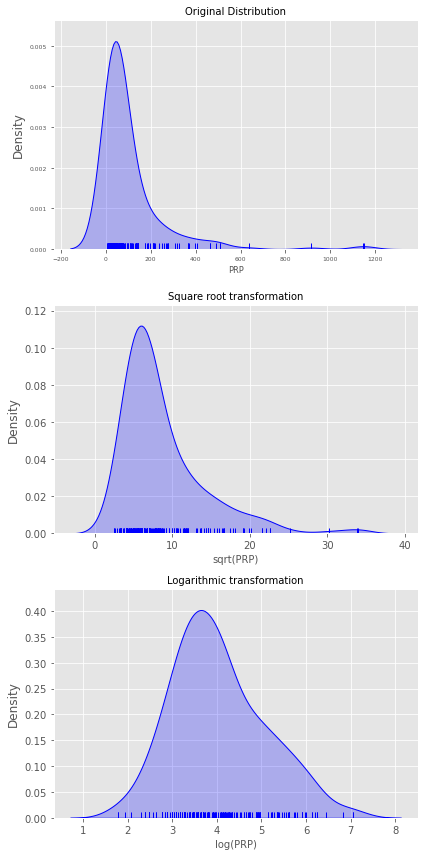

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 12))
sns.distplot(
    dataset.PRP,
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[0]
)
axes[0].set_title("Original Distribution", fontsize = 'medium')
axes[0].set_xlabel('PRP', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.distplot(
    np.sqrt(dataset.PRP),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[1]
)
axes[1].set_title("Square root transformation", fontsize = 'medium')
axes[1].set_xlabel('sqrt(PRP)', fontsize='medium') 
axes[1].tick_params(labelsize = 10)

sns.distplot(
    np.log(dataset.PRP),
    hist    = False,
    rug     = True,
    color   = "blue",
    kde_kws = {'shade': True, 'linewidth': 1},
    ax      = axes[2]
)
axes[2].set_title("Logarithmic transformation", fontsize = 'medium')
axes[2].set_xlabel('log(PRP)', fontsize='medium') 
axes[2].tick_params(labelsize = 10)

fig.tight_layout()

In [15]:
distribution = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(dataset.PRP, distributions=distribution)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

,sumsquare_error,aic,bic,kl_div
cauchy,0.000095,1983.614213,-3042.632444,inf
expon,0.000140,2072.617242,-2959.964849,inf
chi2,0.000144,1971.040769,-2949.866711,inf
beta,0.000148,1945.968924,-2938.647443,inf
exponpow,0.000193,1889.626312,-2887.960129,inf
powerlaw,0.000317,1516.788219,-2784.582492,inf
logistic,0.000358,2532.284014,-2764.277526,inf
norm,0.000465,2493.804996,-2709.609298,inf
gamma,0.000523,5731.337212,-2679.542364,inf


In [16]:
# Num Variables
# ==============================================================================
dataset.select_dtypes(include=['float64', 'int']).describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


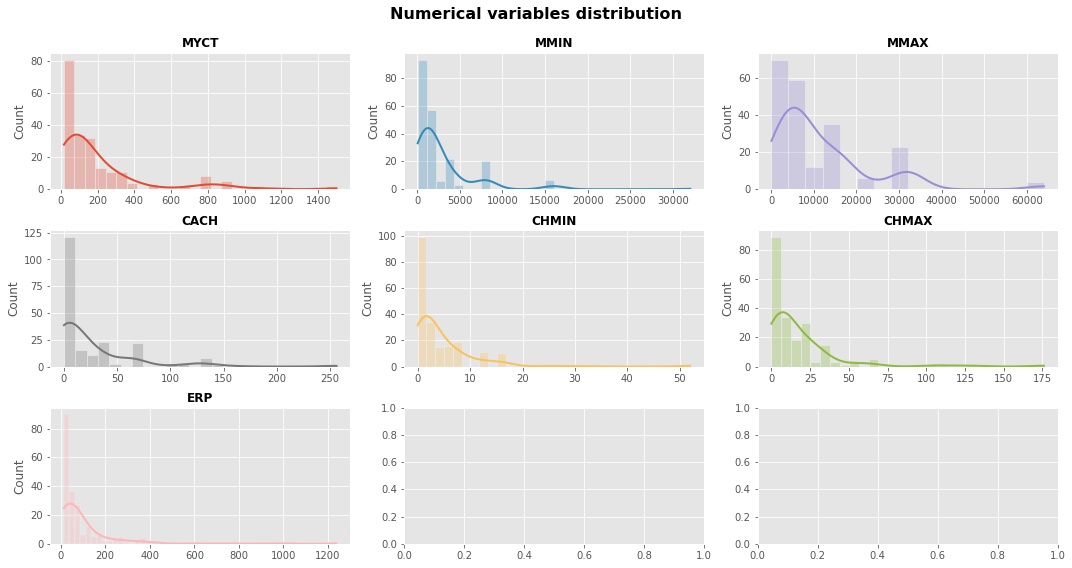

In [17]:
# Distribution graph for each numerical variable
# ==============================================================================
# Adjust number of subplots based on the number of columns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
axes = axes.flat
num_columns = dataset.select_dtypes(include=['float64', 'int']).columns
num_columns = num_columns.drop('PRP')

for i, colum in enumerate(num_columns):
    sns.histplot(
        data    = dataset,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 10)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Numerical variables distribution', fontsize = 16, fontweight = "bold");

The CACH variable, although of type numeric, takes a few values. In cases like this, it is often convenient to treat the variable as qualitative.

In [18]:
# Observed CACH values
# ==============================================================================
dataset.CACH.value_counts()

0      69
8      31
32     23
64     20
16     14
4       8
24      7
128     6
6       5
30      4
2       4
131     2
112     2
65      2
256     2
48      2
1       2
9       2
96      1
12      1
142     1
160     1
Name: CACH, dtype: int64

In [19]:
# The string type CACH variable is converted
# ==============================================================================
dataset.CACH = dataset.CACH.astype("str")

As the objective of the study is to predict the cpu relative performance, the analysis of each variable is also done in relation to the PRP response variable. By analyzing the data in this way, you can begin to get ideas about which variables are most related to PRP and in what way.

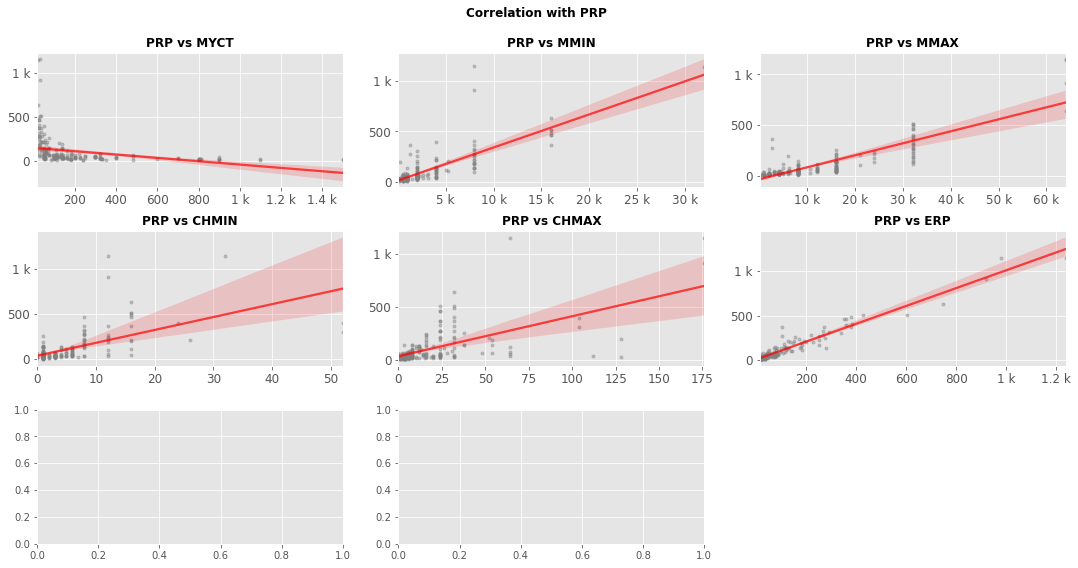

In [20]:
# Distribution graph for each numerical variable
# ==============================================================================
# Adjust number of subplots based on the number of columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 8))
axes = axes.flat
num_columns = dataset.select_dtypes(include=['float64', 'int']).columns
num_columns = num_columns.drop('PRP')

for i, colum in enumerate(num_columns):
    sns.regplot(
        x           = dataset[colum],
        y           = dataset['PRP'],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title(f"PRP vs {colum}", fontsize = 12, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Empty axes are removed
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlation with PRP', fontsize = 12, fontweight = "bold");

Some models suffer if they incorporate highly correlated predictors. For this reason, it is convenient to study the degree of correlation between the available variables.

In [21]:
# Correlation between numeric columns
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Function to convert a pandas correlation matrix to tidy format
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = dataset.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
47,ERP,PRP,0.966472,0.966472
41,PRP,ERP,0.966472,0.966472
20,MMAX,ERP,0.901202,0.901202
44,ERP,MMAX,0.901202,0.901202
19,MMAX,PRP,0.863004,0.863004
37,PRP,MMAX,0.863004,0.863004
13,MMIN,ERP,0.819292,0.819292
43,ERP,MMIN,0.819292,0.819292
12,MMIN,PRP,0.794931,0.794931
36,PRP,MMIN,0.794931,0.794931


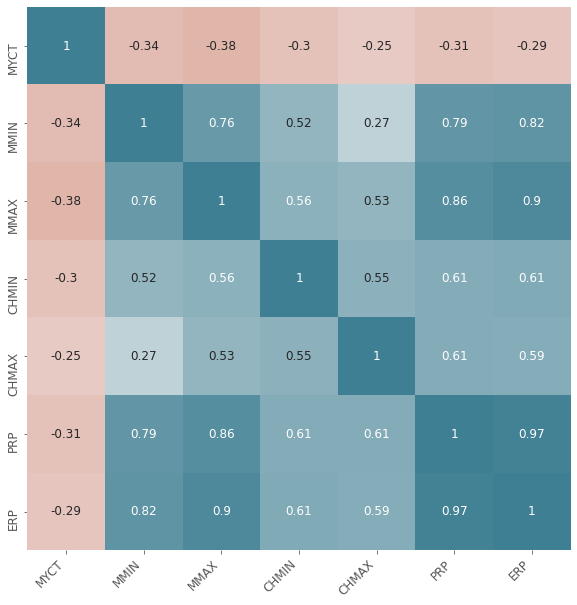

In [22]:
# Heatmap matrix of correlations
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 12},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 12)

In [23]:
# Qualitative variables (object type)
# ==============================================================================
dataset.select_dtypes(include=['object']).describe()

,Vendor Name,Model Name,CACH
count,209,209,209
unique,30,209,22
top,ibm,vax:11/750,0
freq,32,1,69


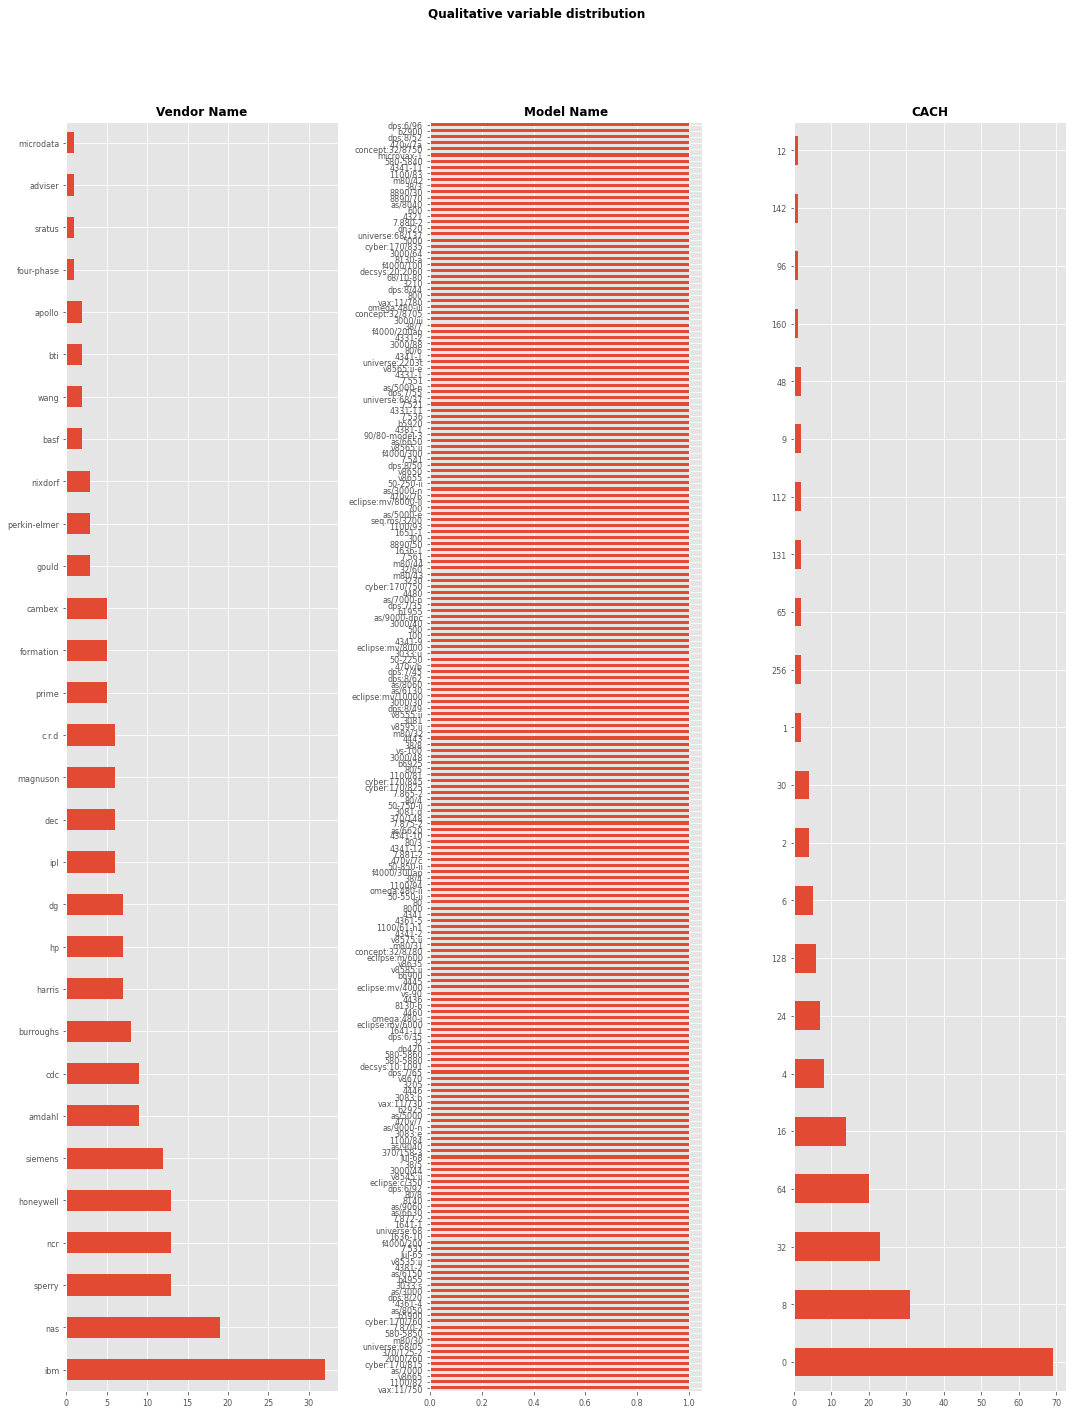

In [24]:
# Graph for each qualitative variable
# ==============================================================================
# Adjust number of subplots based on the number of columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 20))
axes = axes.flat
object_columns = dataset.select_dtypes(include=['object']).columns

for i, colum in enumerate(object_columns):
    dataset[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 12, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")

# Empty axes are removed
#for i in [7, 8]:
#    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Qualitative variable distribution',
             fontsize = 12, fontweight = "bold");

If any of the levels of a qualitative variable have very few observations compared to the other levels, it may happen that, during cross-validation, some partitions do not contain any observations of that class (zero variance), which can lead to errors . In these cases, it is usually convenient:

Eliminate the minority group observations if it is a multiclass variable.

Delete the variable if it only has two levels.

Group minority levels into a single group.

Ensure that, when creating partitions, all groups are represented in each one of them.

In this case, you have to be careful with the CACH variable. Levels 4 upwards are unified into a new level called "4_plus".

In [25]:
dataset.CACH.value_counts(sort=True).sort_index()

0      69
1       2
112     2
12      1
128     6
131     2
142     1
16     14
160     1
2       4
24      7
256     2
30      4
32     23
4       8
48      2
6       5
64     20
65      2
8      31
9       2
96      1
Name: CACH, dtype: int64

In [26]:
dic_replace = {'4': "4_plus",
               '24': "4_plus",
               '128': "4_plus",
               '6' : "4_plus",
               '2' : "4_plus",
               '30' : "4_plus",
               '131' : "4_plus",
               '1' : "4_plus",
               '48' : "4_plus",
               '112' : "4_plus",
               '9' : "4_plus",
               '256' : "4_plus",
               '65' : "4_plus",
               '160' : "4_plus",
               '12' : "4_plus",
               '96' : "4_plus",
               '142' : "4_plus"}

dataset['CACH'] = dataset['CACH'] \
                     .map(dic_replace) \
                     .fillna(dataset['CACH'])

In [27]:
dataset.CACH.value_counts(sort=True).sort_index()

0         69
16        14
32        23
4_plus    52
64        20
8         31
Name: CACH, dtype: int64

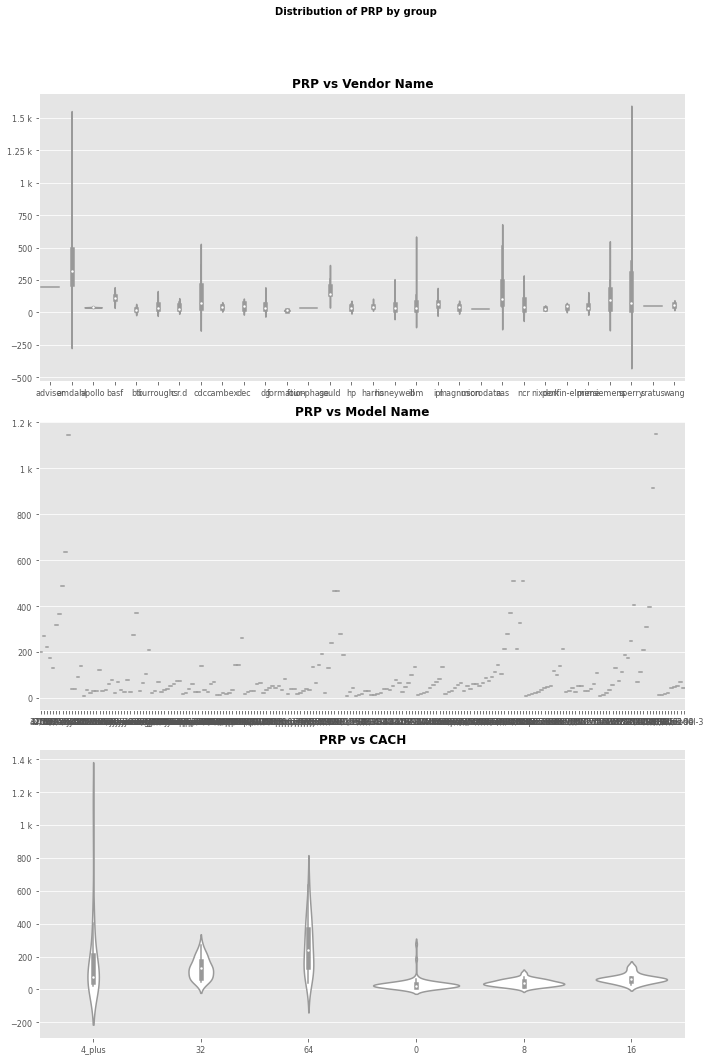

In [28]:
# Graph of the relationship between the PRP and each qualitative variable
# ==============================================================================
# Adjust number of subplots based on the number of columns
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))
axes = axes.flat
object_columns = dataset.select_dtypes(include=['object']).columns

for i, colum in enumerate(object_columns):
    sns.violinplot(
        x     = colum,
        y     = 'PRP',
        data  = dataset,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"PRP vs {colum}", fontsize = 12, fontweight = "bold")
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
#for i in [7, 8]:
#    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribution of PRP by group', fontsize = 10, fontweight = "bold");

Evaluating the predictive capacity of a model consists of checking how close its predictions are to the true values of the response variable. The available data is divided into a training set and a test set. The proper size of the partitions depends largely on the amount of data available and the security that is needed in estimating the error, 80% -20% usually gives good results.

In [29]:
# Distribution of data in train and test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        dataset.drop('PRP', axis = 'columns'),
                                        dataset['PRP'],
                                        train_size   = 0.8,
                                        random_state = 21,
                                        shuffle      = True
                                    )

In [30]:
print("Training partition")
print("-----------------------")
print(y_train.describe())

Training partition
-----------------------
count     167.000000
mean       92.982036
std       135.511413
min         6.000000
25%        25.000000
50%        44.000000
75%        92.500000
max      1150.000000
Name: PRP, dtype: float64


In [31]:
print("Test partition")
print("-----------------------")
print(y_test.describe())

Test partition
-----------------------
count      42.000000
mean      155.880952
std       231.598391
min        12.000000
25%        36.250000
50%        62.000000
75%       138.000000
max      1144.000000
Name: PRP, dtype: float64


In [35]:
# Selection of variables by type
# ==============================================================================
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())
                        ]
                      )


# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[
                                ('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))
                            ]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )


Once the ColumnTransformer object has been defined, the fit () method learns the transformations with the training data and applies them to the two sets with transform ()

In [36]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

The result returned by ColumnTransformer is a numpy array, so the column names are lost. It is usually interesting to be able to inspect how the dataset looks after preprocessing in dataframe format. By default, OneHotEncoder sorts new columns alphabetically from left to right.

In [37]:
# Convert the output to a dataframe and add the name of the columns
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
data_train_prep = preprocessor.transform(X_train)
data_train_prep = pd.DataFrame(data_train_prep, columns=labels)
data_train_prep.info()

ValueError: Shape of passed values is (167, 1), indices imply (167, 209)

In [38]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['MYCT', 'MMIN', 'MMAX', 'CHMIN', 'CHMAX',
                                  'ERP']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Vendor Name', 'Model Name', 'CACH'])])

In [39]:
set_config(display='text')

The next step after defining the training data is to select the algorithm to be used.

In [40]:
from sklearn.linear_model import Ridge

# Preprocessing
# ==============================================================================

# Identification of numerical and categorical columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformations for numeric variables
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformations for categorical variables
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Pipeline
# ==============================================================================

# The preprocessing steps and the model are combined in the same pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================
# The result is assigned to _ so that it is not printed on the screen
_ = pipe.fit(X=X_train, y=y_train)

In [41]:
# Cross-Validation
# ==============================================================================
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )

print(f"Cross validation metrics: {cv_scores}")
print(f"Average cross-validation metrics: {cv_scores.mean()}")

Cross validation metrics: [-68.83101248 -35.53113684 -54.72882391 -43.20639084 -19.44451367]
Average cross-validation metrics: -44.348375546844366


In [43]:
# Validación cruzada repetida con múltiples métricas
# ==============================================================================
from sklearn.model_selection import cross_validate

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

,fit_time,score_time,test_r2,train_r2,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
0,0.068645,0.023598,0.848923,0.988407,-40.745531,-15.891940
1,0.061131,0.031984,0.885515,0.975287,-61.274609,-16.292333
2,0.058238,0.040526,0.767520,0.991521,-49.227147,-13.687444
3,0.058517,0.026461,0.952387,0.975332,-38.308414,-17.139116
4,0.073785,0.030301,0.855833,0.990465,-45.534450,-13.821490
5,0.048583,0.023949,0.896622,0.986555,-30.496443,-17.461231
6,0.050299,0.039645,0.819589,0.990851,-74.510646,-10.396107
7,0.057281,0.036961,0.909943,0.986282,-38.314288,-16.217517
8,0.045660,0.022723,0.878318,0.986472,-28.619493,-17.845142
9,0.054185,0.025535,0.800565,0.993716,-55.173934,-11.140904


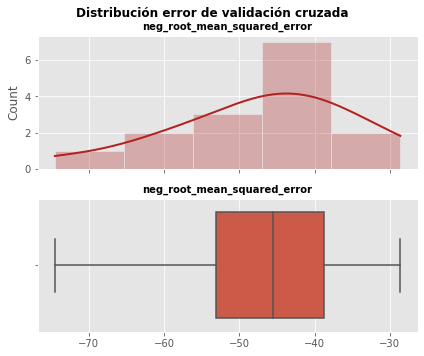

In [45]:
# Distribución del error de validación cruzada
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)

sns.histplot(
    data    = cv_scores['test_neg_root_mean_squared_error'],
    stat    = "count",
    kde     = True,
    line_kws= {'linewidth': 2},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
)

axes[0].set_title('neg_root_mean_squared_error', fontsize = 10, fontweight = "bold")
axes[0].tick_params(labelsize = 10)
axes[0].set_xlabel("")
    
sns.boxplot(
    cv_scores['test_neg_root_mean_squared_error'],
    ax      = axes[1]
)
axes[1].set_title('neg_root_mean_squared_error', fontsize = 10, fontweight = "bold")
axes[1].tick_params(labelsize = 10)
axes[1].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución error de validación cruzada', fontsize = 12,
             fontweight = "bold");

Once the model has been trained, new observations can be predicted with the .predict () method.

In [49]:
predictions = pipe.predict(X_test)

In [50]:
# A dataframe is created with the predictions and the actual value
df_predictions = pd.DataFrame({'PRP' : y_test, 'prediction' : predictions})
df_predictions.head()

,PRP,prediction
156,510,704.355279
17,28,36.675006
54,26,49.984991
6,367,424.615716
9,1144,1387.073847
